Copyright 2022 d-Analytics. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [31]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import correlate
%matplotlib inline
plt.rcParams.update({'font.size': 8})

# Signal Model

The **pilot** $p(t)$ is a *linear* sweep ranging between $f_0$ and $f_1$ Hz,

$$
p(t) = \sin(\phi(t))\quad t\in[0,T]
$$

where the *instantenous* phase $\phi$ is given as,

$$
\phi(t) := 2 \pi \Big(f_0 t + \frac{f_1 - f_0}{2 T} t^2 \Big), \quad t\in[0,T]
$$

and the **signal** $S(t)$ is given as the sum of the pilot signal with a *stationary* (wss) Gaussian process $N(t)\sim \mathcal{GP}(\mu,k(t-t'))$,

$$
S(t) := p(t) + N(t), \quad 
$$

I'll assume that the covariance (kernel) function $k(t-t')$ is given as,

$$
k(t-t') = \sigma^2 \delta (t-t')
$$

where $\delta(x)$ is the Kronecker delta function; this assumption is reasonable for disrete and sufficiently coarsely sampled data.

In [96]:
def genSweep(f0, f1, T, dt, num_pad,phase_distortion):
  'Linear sweep generator'
  assert f0 > 0 and f1 > f0, 'The following condition was not met: 0 < f0 < f1'
  siglen = int(np.ceil(T/dt))
  x=np.linspace(0,T,siglen)
  phi_dist = np.random.normal(loc=0,scale=2*np.pi*phase_distortion,size=x.size)
  signal = np.concatenate((np.sin(2.*np.pi*(f0*x+((f1-f0)/(2*T))*x**2) + phi_dist),np.zeros(num_pad)))
  pilot = np.sin(2.*np.pi*(f0*x+((f1-f0)/(2*T))*x**2))
  return signal, pilot

In [97]:
def plotResults(sig,titlestr):   
  fig, axs=plt.subplots(nrows=1, ncols=1, figsize=(12,5), dpi=150)
  idxSigmin, idxSigmax = 0, len(sig)
  idx=np.arange(len(sig))
  axs.plot(idx[idxSigmin:idxSigmax],sig[idxSigmin:idxSigmax])
  axs.set_xlabel('Sample')
  axs.set_xlim(idx[0],idx[-1])
  axs.set_title(label=titlestr,fontdict=None, loc='center', pad=None)
 
  #fig.tight_layout()
  plt.show()

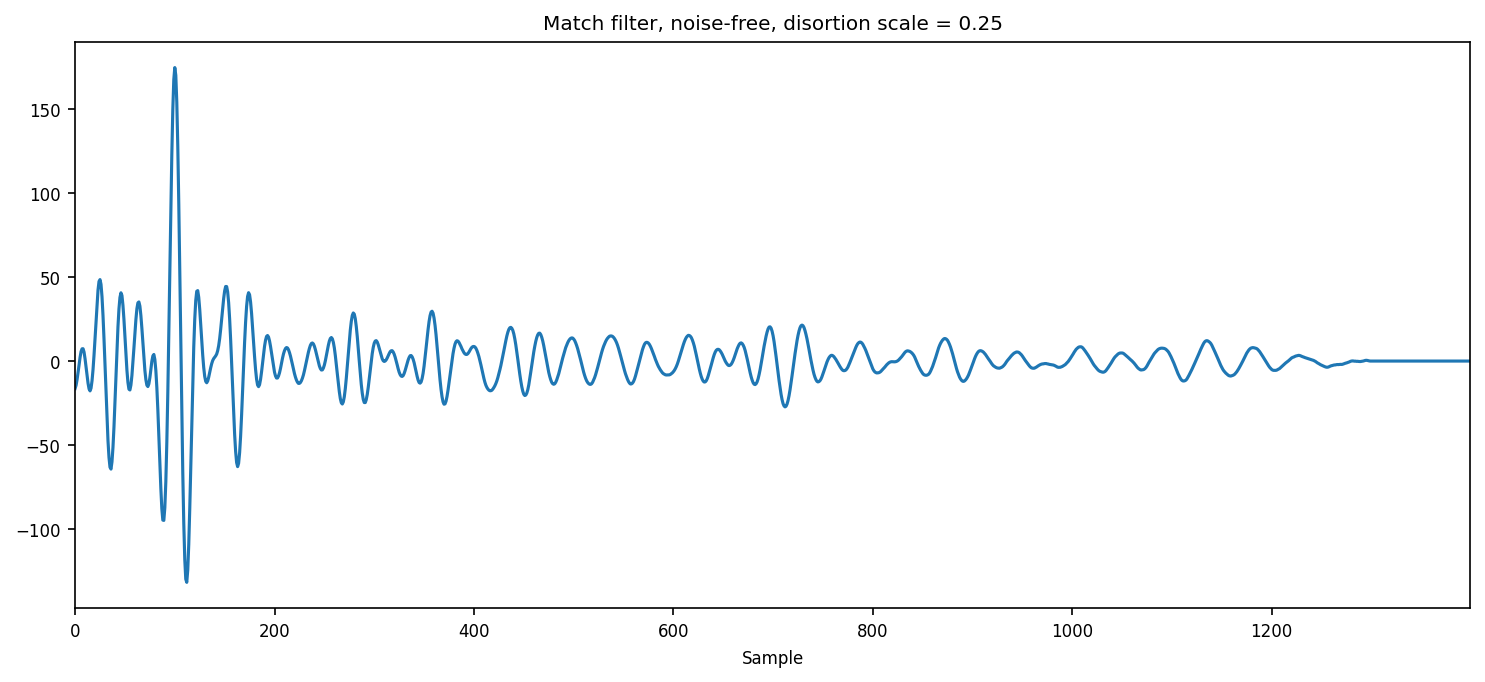

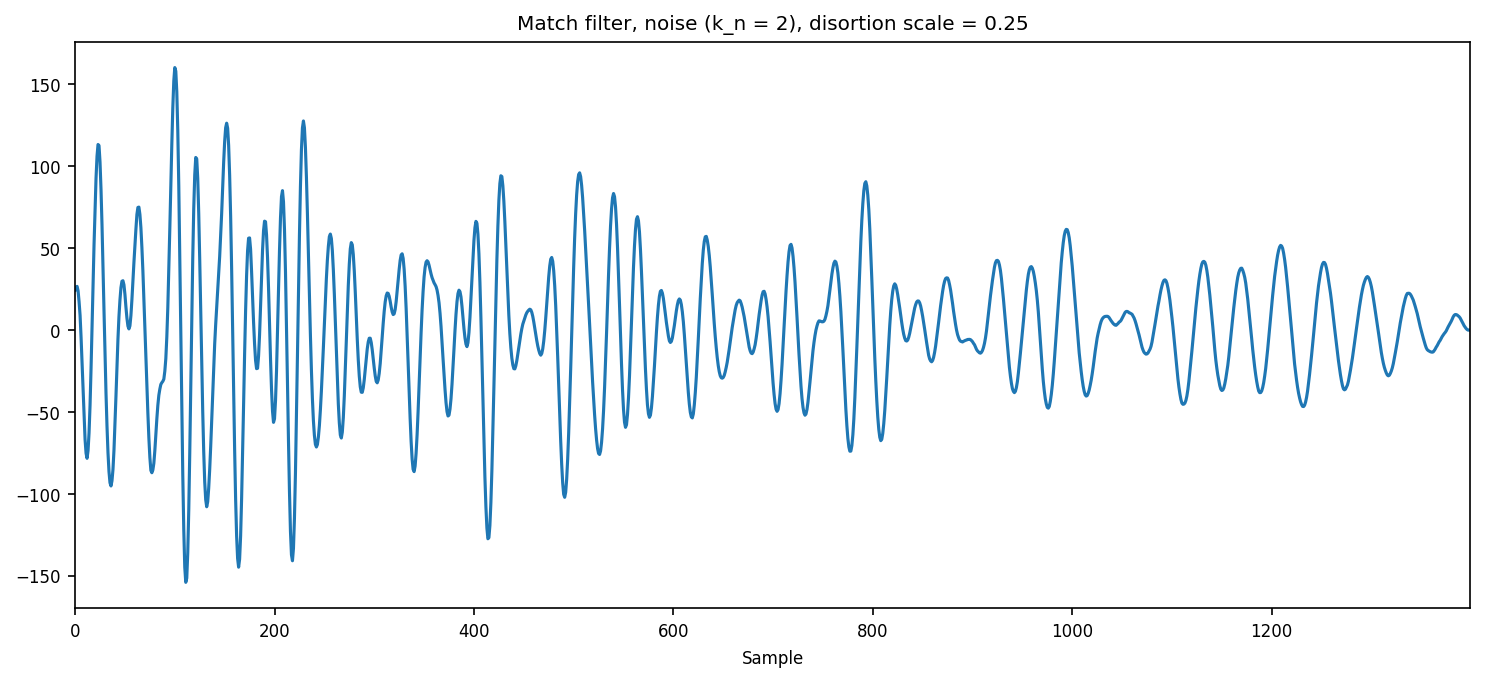

In [98]:
#--- generate signal
num_pad = 100
phase_distortion = 0.25
signal, pilot = genSweep(f0=1000.0,f1=3000,T=24e-3,dt=1/50e3,num_pad=num_pad,phase_distortion=phase_distortion) # sweep
# plotResults(signal)

#--- match filtering
filt = pilot[:len(signal)]
pc_signal = correlate(signal,filt,mode='full')
plotResults(pc_signal[len(filt)-1-num_pad:],f'Match filter, noise-free, disortion scale = {phase_distortion}')

#--- match filtering + noise
k_n = 2
noise = np.random.normal(loc=0,scale=k_n*signal.max(),size=signal.size)
pc_signal_wn = correlate(signal+noise,filt,mode='full')
plotResults(pc_signal_wn[len(filt)-1-num_pad:],f'Match filter, noise (k_n = {k_n}), disortion scale = {phase_distortion}')
# plotResults(pc_signal)